Author: Abdulrahman Altahhan, 2024.

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Lesson 18: RL Application on Games

**Learning outcomes**
1. understand how to create a simple wrapper for a Gym environment to take advantage of its provided functionality
1. understand how to integrate our previous classes with Gym to combine them in a powerful way
1. appreciate the intricacy of applying RL to different domains such as games and robotics
1. build on previous concepts to come up with suitable and sometimes novel algorithms to solve a problem at hand
1. understand how to combine deep reinforcement learning with deep learning to create a powerful framework that allows automatic agent learning by observation or self-play.
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence for difficult problems that involve image processing and reinforcement learning


## Dependencies

Let us first install the gym environment and other dependencies including tensorflow and keras.

Let us test if it is working

In [1]:
!pip3 show tensorflow

/bin/pip3:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
Name: tensorflow
Version: 2.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/rl/.local/lib/python3.8/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wrapt, tensorflow-io-gcs-filesystem
Required-by: 


You should be able to see the location of your tensorflow. If you cannot you might need to do: sudo nano ~/.bashrc and append the tensorflow path as follows (be mindful to the python version, yours might be > 3.6)

export PYTHONPATH=/home/user/.local/lib/python3.6/site-packages:$PYTHONPATH.

We can also check if our GPU is defined as follows.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# or
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-05-06 09:48:12.076221: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 09:48:17.750243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 09:48:17.768049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 09:48:21.351978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8559295629388873333
xla_global_id: -1
]
2024-05-06 09:48:26.056521: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 09:48:26.108027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 09:48:26.108689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 09:48:27.028070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[]


To run this notebook on a remote Azure lab server check this [link](https://docs.microsoft.com/en-us/azure/lab-services/class-type-jupyter-notebook#template-virtual-machine)

**Reading**:
The accompanying reading of this lesson is **chapter 16** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

This lesson deals with [gym openai](https://gym.openai.com/). OPenAI Gym provides a rich set of libraries and environments to try our algorithms on. These include the Atari games the DQN used in their Nature [paper](https://storage.googleapis.com/deepmind-media/DQN/DQNNaturePaper.pdf) to show that Deep Reinforcement Learning can supersede human performance on Atari games with the *same* generic model that is used in *all* of the presented games. 

This was a big and important breakthrough since, previously, RL applications stayed largely within simpler control environments and required, as it was customary at that time, manual feature extraction. So, when this paper showed that it is feasible to build an end-to-end RL model that can automatically extract useful features that can be used directly in an RL training algorithm without any human engineering or intervention, it was an important landmark in our field. Prior to that, there was the Tesauro Backgammon [TDGammon](https://en.wikipedia.org/wiki/TD-Gammon) as another success story which used a neural network to train a model to learn to play backgammon (see the chapter for more details). 

From that moment on, DeepMind went into a progressive trajectory of successful research and applications in the domain of deep reinforcement learning that reached an unprecedented level of beating the world champion in the game of Go see AlphaGo [paper](https://www.nature.com/articles/nature24270.epdf?author_access_token=VJXbVjaSHxFoctQQ4p2k4tRgN0jAjWel9jnR3ZoTv0PVW4gB86EEpGqTRDtpIz-2rmo8-KG06gqVobU5NSCFeHILHcVFUeMsbvwS-lxjqQGg98faovwjxeTUgZAUMnRQ) and then moved on to create a generic architecture that is capable of self-playing to reach superhuman levels in chess, Go and shogi that they called AlphaZero. Contrary to AlphaGo, AlphaZero did not use any human knowledge to train the model, and it completely started from scratch and let the AI train itself by itself! see [here](https://www.deepmind.com/blog/alphazero-shedding-new-light-on-chess-shogi-and-go). 

Note that even the replay idea is an old idea in RL it just got rehashed and done a bit differently inside a buffer that allows us to conduct learning in mini-batches similar to what we do in supervised learning (since this was tried and tested by the ML community and it is proven to work very well with backpropagation).
Yet, this idea was not new since other researchers have tried batches with RL. The paper's main flair is the impressive performance level that could be achieved via an adequately long period of training, a foot that has not been achieved before.
Note that the replay buffer dictates the choice of an off-policy algorithm i.e. Q-learning, since the replayed experience is old and the agent will be learning from a policy different to the one it pursues.

We expect this trajectory to continue and that RL with robotics will create the next wave of innovation that will hopefully change how we conduct our daily lives. We hope this will lead to positive changes and prosperity in the long run, but that does not prevent mistakes. You will tackle this ethical side in another module. For now, enjoy dealing with the revolutionary side of AI that will change the world!

Ok, let us get started...!

# OpenAI Gym Classical Environment
We first tackle classical environments in OpenAI Gym as useful training for dealing with the library. In particular, we will start with their mountain car environment. We have already created our own class for this problem in the previous lesson, however, here, we will inherit their class, and we will override their rendering mechanism to be able to embed its visualisation in our notebook. 

This is a useful exercise to familiarise ourselves with Gym and verify our findings in the previous lesson. Therefore, we will repeat some of the experiments we conducted in the previous lesson. No commentary is provided as it replicates previous experiments on our newly created class that depends on Gym.
Note that we have already set up our classes in previous lessons to be ready to integrate easily with Gym. We will show this in the following example.

In [3]:
%matplotlib inline

In [4]:
import time
import os
import cv2
from math import floor
import numpy as np
from numpy.random import rand
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

In [5]:
import gym
from gym.envs.classic_control import MountainCarEnv
from gym import wrappers
import pygame
from ale_py import ALEInterface
ale = ALEInterface()

from ale_py.roms import Breakout
# ale.loadROM(Breakout)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [6]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from IPython.display import clear_output

from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [7]:
import nbimporter
from Lesson14_EligibilityTraces_Prediction_Control import *

We start by showing you how to inherit from gym environment. We will do exactly what we did in the previous lesson regarding training a mountain car. This time we will utilise the openai gym environment rendering and 

In [8]:
class MountainCar(MountainCarEnv):
    def __init__(self, ntiles=8, **kw):   #  ω: position window, rd: velocity window
        super().__init__(**kw)
       
        # constants                          
        self.X0,  self.Xn  = -1.2, .5       # position range
        self.Xv0, self.Xvn = -.07, .07      # velocity range
        self.η = 3                          # we rescale by 3 to get the wavy valley/hill

        # for render()
        self.X  = np.linspace(self.X0,  self.Xn, 100)     # car's position
        self.Xv = np.linspace(self.Xv0, self.Xvn, 100)    # car's speed
        self.Y  = np.sin(self.X*self.η)
        
        # for state encoding (indexes)
        self.ntiles  = ntiles
        # number of states is nS*nSd but number of features is nS+nSd with an econdoing power of 2^(nS+nSd)>>nS*nSd!
        self.nF = self.nS = 2*(self.ntiles+1)
        self.nA = 3
        # for compatability
        self.Vstar = None
        
        # reset
        self.x, _ = super().reset()
        self.xv = 0

        # figure setup
        self.figsize = (17, 3)
        #plt.gcf().set_size_inches(self.figsize[0], self.figsize[1])

        self.render_mode="rgb_array"

    def s(self, tilings=1):
        return (tilings*self.ntiles*(self.x  - self.X0 )/(self.Xn  - self.X0 )).astype(int)
    
    def sv(self, tilings=1):
        return int(tilings*self.ntiles*(self.xv - self.Xv0)/(self.Xvn - self.Xv0))

    def reset(self):
        self.x, _ = super().reset(seed=0)
        self.xv = 0
        return self.s_()
        
    def s_(self):
        φ = np.zeros(self.nF)
        φ[self.s()] = 1
        φ[self.sv() + self.ntiles] = 1
        return φ
      
    # for compatibility
    def S_(self):
        return np.eye(self.nF)
    
    def isatgoal(self):
        return self.x>=self.Xn
    
    
    def step(self,a):
        obs, r, done, _,_ = super().step(a)
        self.x, self.xv = obs[0], obs[1]
        return self.s_(), r, done, {}

    def render(self, visible=True, pause=0, subplot=131, animate=True, **kw):

        if not visible: return
        self.ax0 = plt.subplot(subplot)
        self.figsize = (17, 3)
        plt.gcf().set_size_inches(self.figsize[0], self.figsize[1])
        plt.imshow(super().render())
        plt.axis('off')
        
        if animate: 
            clear_output(wait=True)
            plt.show(); time.sleep(pause)
        

CPU times: user 42.4 s, sys: 622 ms, total: 43 s
Wall time: 44.1 s


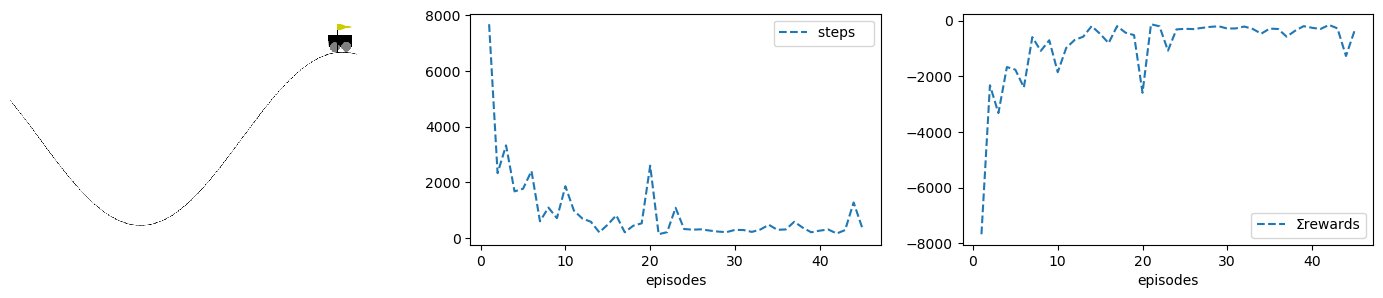

In [9]:
%time sarsa = Sarsa(env=MountainCar(ntiles=8), α=.1/8, episodes=45, seed=1, animate=True, **demoTR()).interact()

Note that we were only showing the end state in each episode and not the whole training process. We can make the process faster by not showing(animating) the training progress as we do below.

CPU times: user 27.5 s, sys: 347 ms, total: 27.9 s
Wall time: 28.3 s


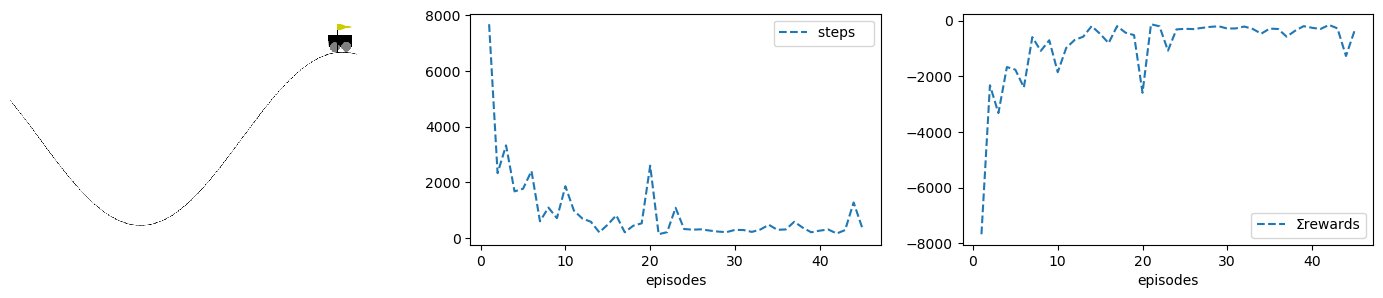

In [10]:
%time sarsa = Sarsa(env=MountainCar(ntiles=8), α=.1/8, episodes=45, seed=1, **demoTR()).interact()

No exploration

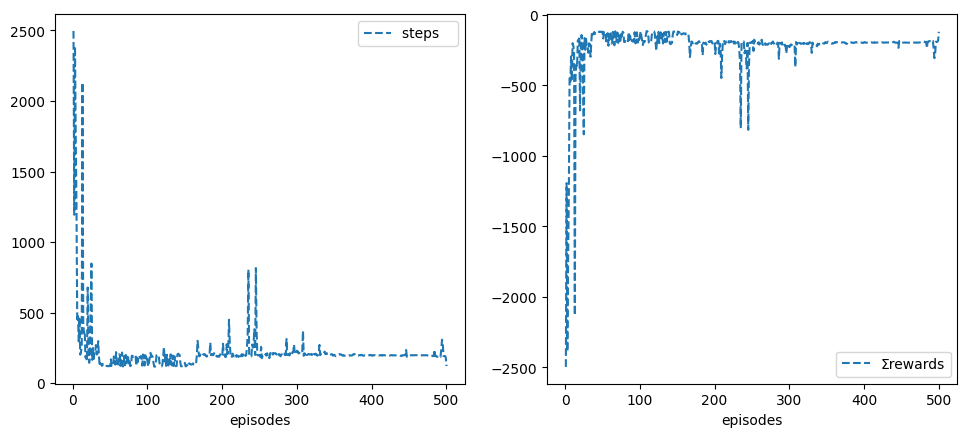

In [13]:
sarsa = Sarsa(env=MountainCar(ntiles=8), α=.3/8, ε=0, episodes=500, seed=1, plotT=True, plotR=True).interact()

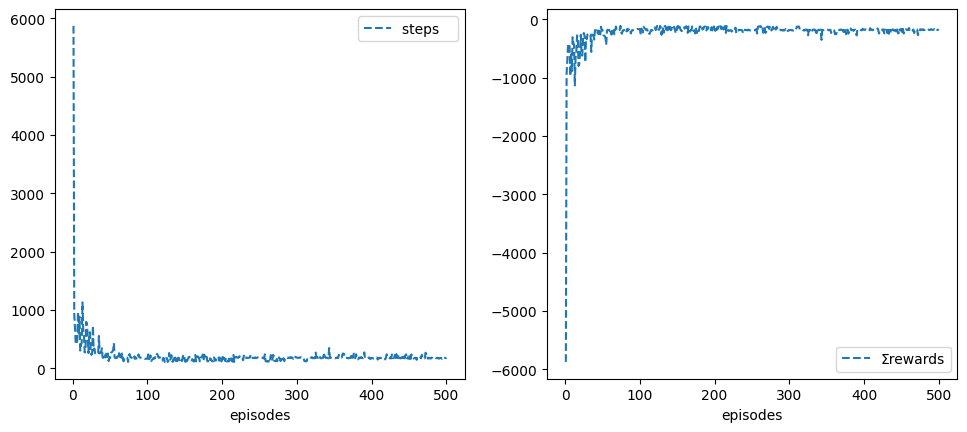

In [14]:
sarsa = Sarsa(env=MountainCar(ntiles=16), α=.3/8, ε=0, episodes=500, seed=1, plotT=True, plotR=True).interact()

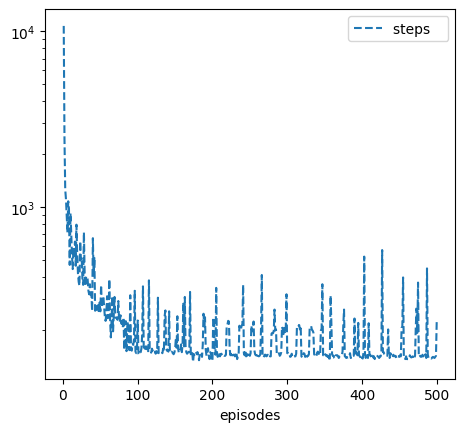

In [15]:
sarsa = Sarsa(env=MountainCar(ntiles=32), α=.3/8, ε=0, episodes=500, seed=1, plotT=True).interact()
plt.yscale('log')

100%|██████████████████████████████████████████████| 20/20 [01:08<00:00,  3.44s/it]


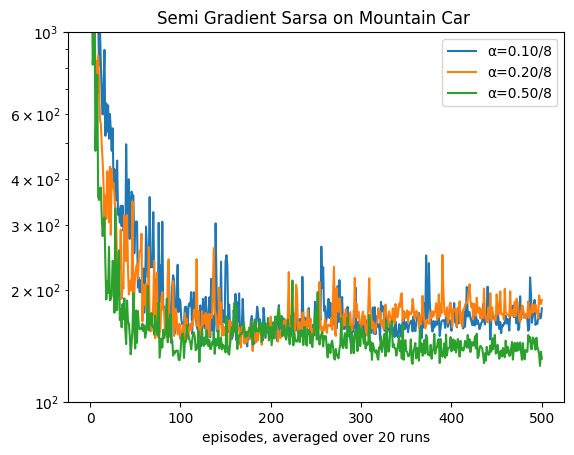

In [16]:
MountainCarRuns()

To run similar experiments that we did in the previous lesson we need to use the tiledMountainCar class.
Below we restate the tiledMountainCar class that we developed in the previous lesson. No changes here except that it inherits now from the new MountainCar cvlass that uses gym MountainCarEnv class. We could have avoided this by putting tiledMountainCar in a class factory function. This is left for you as an exercise.

In [17]:
class tiledMountainCar(MountainCar):
    def __init__(self, ntilings=1, **kw): #ntilings: is number of tiles
        super().__init__(**kw)
        self.ntilings = ntilings
        self.dim = (self.ntilings, self.ntiles+2, self.ntiles+3) # the redundancy to mach the displacements of position(x) and velocity(xv)
        self.nF = self.dim[0]*self.dim[1]*self.dim[2]


    def inds(self):
        s_tiling = self.s(self.ntilings)
        sv_tiling = self.sv(self.ntilings)
        
        inds = []
        for tiling in range(self.ntilings):
            s  = (s_tiling  + 1*tiling )//self.ntilings
            sv = (sv_tiling + 3*tiling )//self.ntilings
            
            inds.append((tiling,s,sv))
        
        return inds
    
    def s_(self):
        φ = np.zeros(self.dim)
        for ind in self.inds(): 
            φ[ind]=1
        
        return φ.flatten()


100%|████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


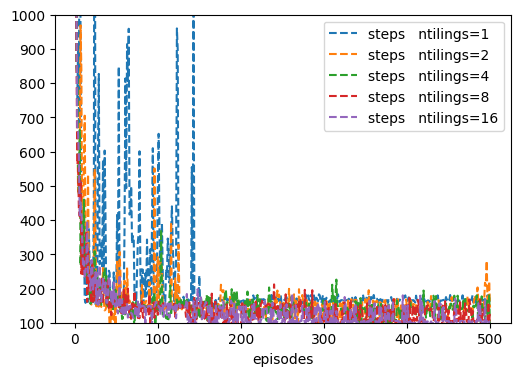

In [18]:
for n in trange(5):
    SarsaOnMountainCar(ntilings=2**n)

100%|██████████████████████████████████████████████| 10/10 [01:17<00:00,  7.72s/it]


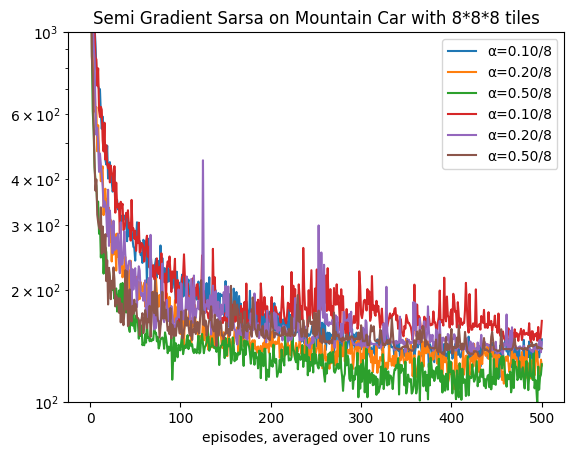

In [19]:
MountainCarRuns(runs=10, env=IHTtiledMountainCar(ntilings=8,ntiles=8), label='with index hashed table for 8*8*8 tiles')
MountainCarRuns(runs=10, env=tiledMountainCar(ntilings=8,ntiles=8), label='with 8*8*8 tiles')

In [20]:
class IHTtiledMountainCar(tiledMountainCar):
    def __init__(self, iht_size=1024, **kw): # by default we have 8*8*8 (position tiles * velocity tiles * tilings)
        super().__init__(**kw)
        self.nF = iht_size


    def s_(self):
        φ = np.zeros(self.nF)
        inds = np.where(super().s_()!=0)[0]
        φ[inds%self.nF]=1
        return φ


100%|██████████████████████████████████████████████| 20/20 [01:56<00:00,  5.85s/it]


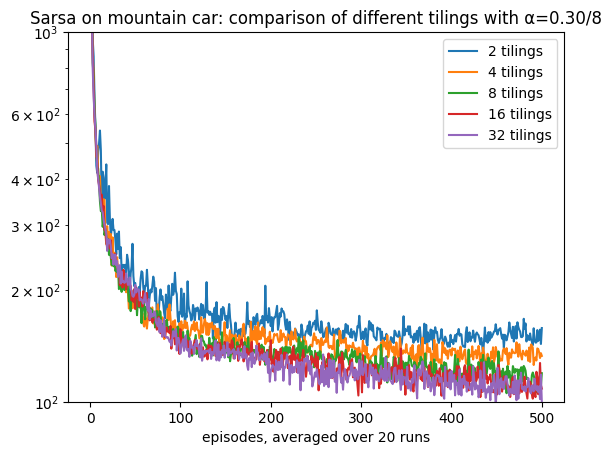

In [21]:
MountainCarTilings()

As we can see we got identical results to the same experiments that we ran in the previous lesson.

#  OpenAI Gym Atari Games Environments
Now we are ready to move to our Atari environment. To be able to follow the logic it is better if you read the Nature paper since most tutorial follow the deep learning architecture that the paper presented. Note that the deep neural network architecture is just three CNNs, nevertheless the paper pioneered and showed the effectiveness of combing deep learning with reinforcement learning. The paper has few inventions such as the experience replay buffer and the batch training something which had not been done successfully before in RL in such a context. The main contribution is to prove that RL is generic enough to be applied to learn from images just as human learn to play a game. Note that the algorithm needed to be an off-policy because of the usage of the experience replay buffer. The use of experience replay means that the agent is learning its current policy from an old experience that stemmed from following an old policy (previous version of its current policy). 


Note that in terms of theory we are still lagging to prove convergence of such approaches. This is where we can be uncertain which shadow of doubt on the ethical controllability of our own creation.

## Atari Gym Wrapper
Let us now build our own wrapper for Atari game so that we are able to apply Deep Q-Learning on the screen pixels coming from the environment. We have equipped our environment with necessary video storing as well as with pre-processing and to be able to handle the frames of the Gym environment. Note that we are dealing with environments that do not perform skipping to avoid the stochasticity associated with randomly applying actions. Therefore, we had to do the frame skipping in the wrapper class. It is also sufficient to deal with grey scale images not RGB since this will reduce the processing demands on our machines. Feel free to experiments with the GymEnv class to change its underlying preprocessing and or its assumptions.

In [14]:
def GymEnvi(Wrapper=gym.Wrapper):
    
    class GymEnvi(Wrapper):
        def __init__(self, env_name='ALE/Pong-v5', seed=0,   # 'PongNoimgskip-v4'
                     nimgs_skip=4, nimgs_stack=1, img_size=(84, 84), 
                     video=True, i=0, animate=False, saveimg=False):

            # if Wrapper==gym.Wrapper:
            super().__init__(gym.make(env_name, render_mode='rgb_array'))
                
            self.nA = 3 if 'Pong' in env_name else self.action_space.n 
            self.env_name = env_name
            # seeding the game for consistency when testing
            # self.env.seed(seed)
        
            self.animate = animate
            self.saveimg = saveimg
            self.nimgs_skip = nimgs_skip      # how many imgs will be skipped to form one step
            self.imgs_skip  = deque(maxlen=2)   # a buffer to store last few imgs that will take their max

            self.nimgs_stack = nimgs_stack    # how many imgs will be put together to form a one state (we use first and last only)
            self.img_size    = img_size       # (w,h)how much reduction will be applied on the original imgs
            self.img_size_   = (*img_size, max(1,nimgs_stack)) # extended dimension of state space
            self.imgs_stack  = deque(maxlen=nimgs_stack)


            self.nS = 10 # for compatibility
            self.i = i   # video number

            # ineffective for compatibility 
            self.Vstar = None

            # for rendering and video
            self.ax0 = None
            self.figsize = (20, 4)
            self.video = video
            self.video_imgs  = []
            self.video_imgs_ = []

        # self.s holds the latest img *after* preprocessing (state/observation seen by the agent)
        def preprocess(self, img):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, self.img_size) / 255
            self.s = np.expand_dims(img, -1)
            return self.s 

        # self.img holds the latest img *before* preprocessing (will be used for videos)
        def step(self, a):
            if a and 'Pong' in self.env_name: a+=1 # suitable for pong only
            self.a = a
            self.r = 0
            # skip 4 imgs (apply same action) and stack last 2 imgs then take their max
            for i in range(self.nimgs_skip):
                img, r, self.done, _, _ = self.env.step(a)
                self.r += r
                self.imgs_skip.append(img)
                if self.done: break

            img = self.preprocess(np.stack(self.imgs_skip).max(axis=0))
            self.imgs_stack.append(img)

            # stack only the first and last imgs to save computation and to convey movement direction to the model
            img_inds = [0,-1] if self.nimgs_stack>1 else [0]
            self.img = np.dstack([self.imgs_stack[i] for i in img_inds ])

            return self.img, self.r, self.done, {}

        def reset(self):
            self.imgs_skip.clear()
            self.imgs_stack.clear()

            # reset the environment and retain its initial state (image) 
            img = self.env.reset()[0]
            self.imgs_skip.append(img)
            img = self.preprocess(img)

            # now stack the same img n times for consistency with step()
            for _ in range(self.nimgs_stack):
                self.imgs_stack.append(img)
                
            img_inds = [0,-1] if self.nimgs_stack>1 else [0]
            self.img = np.dstack([self.imgs_stack[i] for i in img_inds ])

            return self.img 

        #------------------------------------------render ✍️-------------------------------------------------
        def render(self, visible=True, pause=0, subplot=131,  animate=True, **kw):

            if not visible: return

            self.ax0 = plt.subplot(subplot)
            plt.gcf().set_size_inches(self.figsize[0], self.figsize[1])

            # saving it as a video if needed, note that we render only at the last few episode
            if self.video and animate:
                self.video_imgs.append(self.img)
                plt.axis('off')
                # create the video at the end of the set of episodes
                if self.done:
                    for obsv in self.video_imgs: self.video_imgs_.append([plt.imshow(obsv, cmap=cm.Greys_r, animated=True)])
                    anim = animation.ArtistAnimation(self.ax0.figure, self.video_imgs_, interval=50, blit=True, repeat_delay=1000)
                    anim.save('atari%d.mp4'%self.i)
            img_inds = [0, int(self.nimgs_stack/2), -1] if self.nimgs_stack > 2 else [0]
            img = np.dstack([self.imgs_stack[i] for i in img_inds])

            plt.imshow(img)
            plt.axis('off')
            if animate:
                clear_output(wait=True)
                plt.show()
                time.sleep(pause)

    return GymEnvi

GymEnv = GymEnvi()

Let us create some handy function to play an Atari games and observe the states.

In [19]:
def play(ep=1, env=GymEnv(nimgs_stack=3), render=True): # try nframes_stack=5 it is fun!
    for ep in range(ep):
        env.reset()
        done=False
        for _ in range(50):
            s,r, done, _ = env.step(randint(3))
            if render: env.render(pause=0)
    print(s.shape)
    return s
    


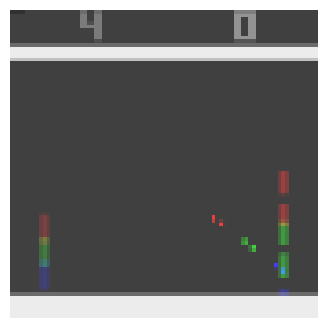

(84, 84, 2)


In [20]:
s = play()

# RL with Deep Learning 
It is time to extend our basic MRP class to handle function approximation using deep neural networks.
Note that in their paper DeepMinds trained for 200M frames, we set the max_t_exp (used in stop_exp() function) to 2M due to hardware limitation. We can also make the stop_exp() tied to R-star that is specific to the game under consideration. For example, in Pong, we can set this to 18. This means that on average (for the last 100 or 200 games/episodes), the opponent could only score *only a max of 3* goals, and our agent scores the wining *21* goals.

### Buffer Implementation
It is better to implement the buffer as queue because it guarantees an O(1) complexity for append() and pop() and it is preferred over the list which gives us a O(n) for adding and retrieving an item. In Python we can utilise the double queue structure which gives us the flexibility to add and retrieve from both ends of the queue. Below, we show a quick example. Note that the buffer will be overwritten when. the number of items exceeds its length. This is useful for us because we just want the buffer to overwritten with new experience after it s full and to be kept updated accordingly.

In [21]:
from collections import deque
buffer = deque(maxlen=5)
buffer.append(1)
buffer.append(2)
buffer.append(3)
buffer.append(4)
print(buffer)

deque([1, 2, 3, 4], maxlen=5)


In [22]:
buffer.append(5)
buffer.append(6)
buffer.append(7)
print(buffer)

deque([3, 4, 5, 6, 7], maxlen=5)


### Sampling form the buffer

In [23]:
import random

random.sample(buffer,2)

[4, 6]

### Buffer with Complex Element (Tuples)
Let us assume that we have a set of tuples each consists of (s,a,sn). In this case we can add these tuples as is. Below we show an example, we have represented actions as integers but states/observations as string to help identifying them visually, but bear in mind that they are going to be a more complex entities such as images.

In [24]:
buffer = deque(maxlen=4)
buffer.append(('2',1,'3'))
buffer.append(('3',2,'4'))
buffer.append(('4',2,'5'))
buffer.append(('5',1,'4'))

print(buffer)

deque([('2', 1, '3'), ('3', 2, '4'), ('4', 2, '5'), ('5', 1, '4')], maxlen=4)


Now in order to sample we can directly sample from the buffer 

In [25]:
batch = random.sample(buffer,3)
print(batch)

[('2', 1, '3'), ('5', 1, '4'), ('3', 2, '4')]


However, the above is not useful, usually we want to place all the actions and states and next states in their own list to feed them as a batch into a neural network. To put all states and actions together each in its own list we can use zip

In [26]:
for i in zip(*batch): print(i)

('2', '5', '3')
(1, 1, 2)
('3', '4', '4')


We can also convert them into a numpy array directly.

In [27]:
[np.array(i) for i in zip(*batch)]

[array(['2', '5', '3'], dtype='<U1'),
 array([1, 1, 2]),
 array(['3', '4', '4'], dtype='<U1')]

In [28]:
buffer = deque(maxlen=4)
buffer.append(('2',1,'3'))
buffer.append(('3',2,'4'))
buffer.append(('4',2,'5'))
buffer.append(('5',1,'4'))

print(buffer)
samples = [np.array(item) for item in zip(*sample(buffer,3))]
print(samples)

deque([('2', 1, '3'), ('3', 2, '4'), ('4', 2, '5'), ('5', 1, '4')], maxlen=4)
[array(['5', '2', '3'], dtype='<U1'), array([1, 1, 2]), array(['4', '3', '4'], dtype='<U1')]


## Deep MRP
In this class we implement the basic functionality for dealing with creating, saving and loading deep learning models. In addition, we make these models the default functions used to obtain the value function via self.V_.
We also adjust the stope_exp criterion so that the algorithm stops when a specific averaged reward is achieved or when a specific *total* number of steps (self.t_ not self.t) have been elapsed. This means also that we free ourselves from the notion of an episode, so our model can run as many episodes as it takes to achieve this total number of steps. We still can assign episodes=x to store metrics for last y episodes where y<x.
Note that nF is usually used in the Env(ironment) class but feature extraction is embedded the model itself in deep learning model so it is defined in the Deep_MRP class.

In [29]:
200000%(int(2e6)*.1)==0

True

In [30]:
env=GymEnv()
env.nA

3

In [37]:
class Deep_MRP(MRP):
    def __init__(self, 
                 env=GymEnv(), 
                 γ=0.99,
                 nF=512, 
                 R_star=None, 
                 last=40,
                 buffer_size=10000, 
                 batch_size=32, 
                 max_t_exp=int(1e6),
                 load_weights=False,
                 print_=False,
                 **kw):

        super().__init__(env=env, γ=γ, last=last, print_=print_, **kw)
        self.nF           = nF # feature extraction is integrated within the deep learning model not the env
        self.R_star       = R_star
        self.buffer_size  = buffer_size
        self.batch_size   = batch_size
        self.load_weights_= load_weights
        self.max_t_exp    = max_t_exp # used to stop learning
    
    def init(self):
        self.vN = self.create_model('V')                      # create V deep network
        if self.load_weights_: self.load_weights(self.vN,'V') # from earlier training proces
        self.vN.summary()
        
        self.V = self.V_

    #-------------------------------------------Deep model related---------------------------
    def create_model(self, net_str):
        print(f'model for {net_str} network is being loaded from disk........!')
        x0 = Input((84,84,1))#self.env.frame_size_)
        x = Conv2D(32, 8, 4, activation='relu')(x0)
        x = Conv2D(64, 4, 2, activation='relu')(x)
        x = Conv2D(64, 3, 1, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(self.nF, 'relu')(x)
        x = Dense(1 if net_str=='V' else self.env.nA)(x) 
        model = Model(x0, x)
        model.compile(Adam(self.α), loss='mse')
        return model

    def load_weights(self, net, net_str ):
        print(f'weights for {net_str} network are being loaded from disk........!')
        loaded_weights = net.load_weights(net_str)
        loaded_weights.assert_consumed()

    def save_weights(self):
        print(f'weights for V network are being saved to disk........!')
        self.vN.save_weights('V')

    #------------------------------------- value related 🧠-----------------------------------
    def V_(self, s):
        if len(s.shape)!=4: 
            # this needs to be tested to make sure it give us the required dim
            return self.vN.predict(np.expand_dims(s, 0))[0]  # prediction for one state for εgreedy to work well
        return np.copy(self.vN.predict(s))  # prediction for a batch of states, we copy to avoid auto-grad issues

    # ------------------------------------ experiments related --------------------------------
    # overriding: we do not specify a preset number of episodes to stop the experiments
    def stop_exp(self):  
        
        if self.ep and self.R_star is not None and self.Rs[:self.ep].mean()>= self.R_star: 
            print(f'target reward is achieved in {self.t_} steps!')
            return True
        
        if self.t_ > self.max_t_exp:
            print(f'max steps of {self.t_} is reached and training is stopped, weights are being saved!')
            self.save_weights()
            return True
        
        # save model's weights at least 10 times during the life of the agent
        if (self.t_+1)%int(.1*self.max_t_exp)==0: self.save_weights()
        return False
    
    # stop_ep must be overriden because otherwise it will stope when max_t is reached
    def stop_ep(self, done): return done
    
    #-------------------------------------------buffer related----------------------------------
    def allocate(self):
        self.buffer = deque(maxlen=self.buffer_size)

    def store_(self, s=None,a=None,rn=None,sn=None,an=None, done=None, t=0):
        self.buffer.append((s, a, rn, sn, done))

    def sample(self):
        # sample a set of batch_size tuples (each tuple has 5 items) without replacement 
        # zip the tuples into one tuple of 5 items and convert each item into a np array 
        # of size batch_size   
        samples = [np.array(experience) for experience in zip(*sample(self.buffer, self.batch_size))]

        # generate a set of indices handy for filtering, to be used in online()
        inds = np.arange(self.batch_size)
        
        return samples, inds


## Deep MDP
Now we create the Deep_MDP class which implements policy related functionality

In [38]:
class Deep_MDP(Deep_MRP):
    def __init__(self, 
                 ε=1.0,  
                 εmin=0.01, 
                 εT=200000,    # linear decay by default
                 t_qNn=1000,   # update the target network every t_qNn steps
                 create_vN=False,
                 **kw):
        
        super().__init__(**kw) 
        self.t_qNn = t_qNn 
        self.create_vN = create_vN
        self.ε = ε
        self.εmin = εmin
        self.εT = εT
    
    def init(self):
        self.create_vN: super().init()                        # to create also vN, suitable for actor-critic
        
        self.qN  = self.create_model('Q')                     # create main policy network
        self.qNn = self.create_model('Q')                     # create target network to estimate Q(sn)
        if self.load_weights_: self.load_weights(self.qN,'Q') # from earlier training proces
        self.qNn.set_weights(self.qN.get_weights())
        
        self.qN.summary()
        
        self.Q = self.Q_

    def save_weights(self):
        if self.create_vN: super().save_weights()
        print(f'weights for Q network are being saved to disk........!')
        self.qN.save_weights('Q')
    #------------------------------------- policies related 🧠-----------------------------------
    def Q_(self, s):
        if len(s.shape)!=4: 
            return self.qN.predict(np.expand_dims(s, 0))[0]  # prediction for one state for εgreedy to work well
        return np.copy(self.qN.predict(s))  # prediction for a batch of states, we copy to avoid auto-grad issues
    
    def Qn(self, sn):
        return self.qNn.predict(sn)    
    #-------------------------------------- 🔍 conditions -----------------------------------------
    
    def online_cond(self):  return len(self.buffer) >= self.buffer_size
    def target_cond(self):  return self.t_ % self.t_qNn==0
        
    #-------------------------------------- 🧠 deep nets updates ----------------------------------- 
    def update_before(self, *args): pass
    def update_after(self, *args): pass
    def update_online_net(self): pass    
    
    # update the target network every now and then
    def update_target_net(self):
        if self.target_cond(): 
            print('assigning weights for target network.....')
            self.qNn.set_weights(self.qN.get_weights())
    

    #------------------------------------- 🌖 online learning --------------------------------------       
    def online(self, *args):
        # make sure the buffer is full before doing any update or sampling
        if self.online_cond(): 
            self.update_before(*args) 
            self.update_target_net()
            self.update_online_net()
            self.update_after(*args)


## Deep Q-Learning Architecture


Note that we need to set ε here otherwise it will be set by default to .1 in the parent class.

In [39]:
class DQN(Deep_MDP):
    def __init__(self, α=1e-4, **kw): 
        print('--------------------- 🧠  DQN is being set up 🧠 -----------------------')
        super().__init__(**kw)
        self.α = α
        
    #------------------------------- 🌖 online learning ---------------------------------
    # update the online network in every step using a batch
    def update_online_net(self):
        # sample a tuple batch: each componenet is a batch of items 
        #(ex. s is a set of states, a is a set of actions)
        (s, a, rn, sn, dones), inds = self.sample() 

        # obtain the action-values estimation from the two networks 
        # and make sure target is 0 for terminal states
        Qs = self.Q(s)
        Qn = self.Qn(sn); Qn[dones] = 0

        # now dictate what the target should have been as per the Q-learning update rule
        Qs[inds, a] = self.γ*Qn.max(1) + rn
        self.qN.fit(s, Qs, verbose=False)


In [40]:
# deal with the Grid states as images and learn from them to navigate it
%time deepqlearn = DQN(env=GymEnv(), episodes=5, max_t_exp=20000, εT=500, buffer_size=10000, batch_size=32).interact() 

--------------------- 🧠  DQN is being set up 🧠 -----------------------
model for Q network is being loaded from disk........!
model for Q network is being loaded from disk........!
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 84, 84, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 20, 32)        2080      
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 9, 64)          32832     
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 3136)              0         
                                                                 
 dense_8 (

In [ ]:
# play pong and take the mean of the last n episodes but will keep going until R.mean() reaches R_star
%time deepqlearn = DQN(env=GymEnv(),R_star=10, episodes=50, max_t_exp=200000, εT=50000, buffer_size=10000, batch_size=32).interact() 

## Double DQN Learning

In [ ]:
class DDQN(DQN):
    def __init__(self, α=1e-4, **kw):
        print('----------- 🧠 Double DQN is being set up 🧠 ---------------------')
        super().__init__(**kw)
        self.α = α
    #--------------------------- 🌖 online learning -----------------------------
    def update_online_net(self):
        # sample a tuple batch: each componenet is a batch of items 
        #(ex. s is a set of states, a is a set of actions) 
        (s, a, rn, sn, dones), inds = self.sample()
        # obtain the action-values estimation from the two networks 
        # and make sure target is 0 for terminal states
        Qs = self.Q(s)
        Qn = self.Qn(sn); Qn[dones] = 0

        # now dictate what the target should have been as per the *Double* Q-learning update rule
        # this is where the max estimations are decoupled from the max action selections
        an_max = self.Q(sn).argmax(1)
        Qs[inds, a] = self.γ*Qn[inds, an_max] + rn
        self.qN.fit(s, Qs, verbose=0)


In [ ]:
# play pong and take the mean of the last n episodes but will keep going until R.mean() reaches R_star
%time doubledeepqlearn = DDQN(env=GymEnv(), episodes=20, buffer_size=10000, batch_size=32).interact() 

## Extracting Features via Auto-Encoders
In this section we show how to use the latent variables of an auto-encoder in order to extract useful features from the frames grabbed from the games. This will allow us to apply previously covered algorithms that can be applied on linear models. For example we can take the latent variables and use them as the input for true online TD($\lambda$). 
Refer to keras [auto-encoder](https://www.tensorflow.org/tutorials/generative/autoencoder) tutorial.

### Build a dataset from a game
Let us collect a dataset from our game by assigning the max_t_exp to be as large as the buffer_size so that the games stops when the buffer is almost full.

In [ ]:
dqn = DQN(env=GymEnv(), buffer_size=41000, max_t_exp=40000).interact() 

Now extract the data frames from the buffer.

In [ ]:
experience = [np.array(experience) for experience in zip(*dqn.buffer)]
frames = experience[0]
x_train, x_test = train_test_split(frames, test_size=0.3, random_state=42)
print('training data size', x_train.shape)
print('testing data size', x_test.shape)


## Conclusion
In this lesson you saw how to deal with a continuous state space using function approximation and how to apply previous concepts on a more difficult control problems. We have built a wrapper class that allowed us to take advantage of the environments provided by OpenAI Gym library. We have duplicated what we have done in the previous lesson in order to 1. examine that our previous environment worked well, 2. see an example of how to deal with OpenAI Gym environment. 

You have also seen how to combine deep learning with reinforcement learning to create a powerful model that is capable of learning from watching a game. This is really interesting since it opens up the possibility for enormous applications where an agent can watch and learn to arrive to a complex behaviour that allows it to accomplish a task or win a competition. 


# Unit's conclusion
This lesson concludes our unit where we have studied important formulation of RL that we use a function approximation to represent the stare space which can be continuous and infinite.

We only expect that the interest is going to continue to grow and that RL with robotics will create the next wave of innovation that will hopefully change the way we conduct our daily lives. We hope that this will lead to positive changes and to prosperity in the long run but that does not prevent mistakes. You will tackle this ethical side in another module, for now enjoy dealing with revolutionary side of AI that will change the world!

Congratulations on completing this last unit on RL!

## Discussion and Activity
Read the following classic Nips [paper](https://deepmind.com/research/publications/2019/playing-atari-deep-reinforcement-learning) and Nature [paper](https://storage.googleapis.com/deepmind-media/DQN/DQNNaturePaper.pdf) and discuss it in the discussion forum.

## Extra Resources
There are plenty of videos and resources which you can search online for.
- You may want to follow the following [tutorial](https://www.tensorflow.org/agents/tutorials/1_t_DQNnutorial#environment) which shows how to deal with tensorflow on cart pole but the input is not the frames.
- You may then follow this [tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#hyperparameters-and-utilities) which uses deep learning on the frames of a cart pole problem.

- You may find it useful to watch this [video](https://www.youtube.com/watch?v=a5XbO5Qgy5w) for a Keras tutorial with RL, or this [video](https://www.youtube.com/watch?v=NP8pXZdU-5U) for a pytorch tutorial with RL. 
- You may want to have a look at some [tutorials](https://neptune.ai/blog/best-reinforcement-learning-tutorials-examples-projects-and-courses).

- You may find see this series of talks about the [future of AI](https://www.bbc.co.uk/sounds/play/m001216j) by Stuart Russell interesting.
- If you are intersted in self-driving cars, then:
    - See the [ALVIN](https://papers.nips.cc/paper/1988/file/812b4ba287f5ee0bc9d43bbf5bbe87fb-Paper.pdf) paper for an early stage vehicle road control neural network, it is an early precursor of the current road systems that control autonomous vehicle. A lot of the new systems retain some similarities with this systems. 
    - See this [video](https://youtu.be/2KMAAmkz9go) of the history of this system. 
    - See this [video](https://youtu.be/sRxaMDDMWQQ) lecture of the topic autonomous vehicle driving.

- **Carla Autonomous Vehicle Simulation**
    - See this [video](https://www.youtube.com/watch?v=pONr1R1dy88) for Carla simulation tutorial 1
    - See this [video](https://www.youtube.com/watch?v=om8klsBj4rc) for Carla simulation tutorial 1


## Your turn

1. try to apply the same concept on other simple environments provided by Gym such as the acrobot.

2. apply DQN on another Atari game such as SpaceInvaders or Breakout and report the score that you got in the discussion forum.

1. try to *think* of way to adopt a more complex neural network architecture that uses a more advanced CNN block in order to advance the state of the art in computer vision such as [EfficentNetV2](https://arxiv.org/pdf/2104.00298.pdf). As a starting point, we should note that this kind of neural networks is designed for classification. I.e. is there a way to deal with RL algorithms as a classification problem not a regression of estimating the value function v?.

## Challenge++
1. check the implementation of the deep network in the [tutorial](https://keras.io/examples/rl/actor_critic_cartpole/) and try to integrate it into the provided infrastructure.